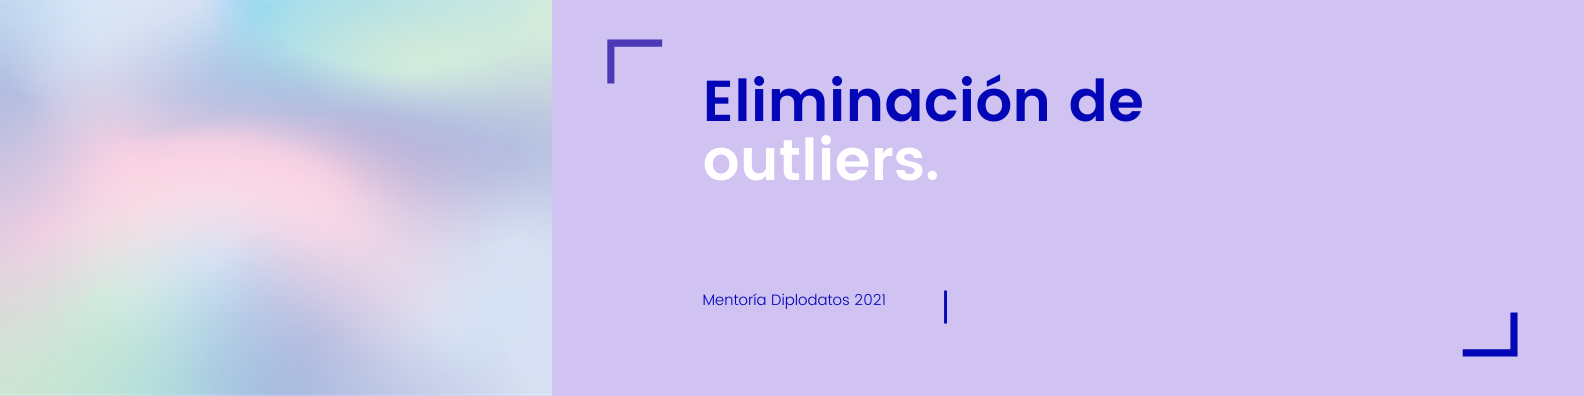

#Eliminación de outliers

Durante el desarrollo de este segundo entregable, fueron apareciendo diferentes situaciones y análisis donde se determinó la aparicion de datos expremos / outliers. La finalidad de esta notebook es centrar en un sólo lugar este filtrado y eliminación, para luego generar un nuevo csv sin estos outliers que afecten los analisis.




In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
import time
import datetime as dt
from IPython.display import HTML, display
import math

seaborn.set_context('talk')

#Análisis de outliers al explorar y analizar la frecuencia de los accesos a la plataforma

Este análisis surgió durante el análisis que puede verse en la otra notebook presente en este entregable.



In [ ]:
url= 'https://raw.githubusercontent.com/laraccano84/Mentoria_mumuki/main/DiploDatos_Mentoria_Mumiki_G2/DataSet_Mumuki_Transformed.csv'
df_mumuki = pd.read_csv(url)
df_mumuki=df_mumuki.drop(columns='Unnamed: 0',axis=1)

In [ ]:
len(df_mumuki)

47099

En este punto, se buscaba estudiar la cantidad de tiempo invertido por estudiante, después de calcular la cantidad dde envios por estudiante.

Se creo un dataset separado `df_student` para poder realizar un análisis especial, y estar seguras de no 'pisar' los datos originales.

Se calcula la columna `tiempo_invertido` como la diferencia entre el primer y el último envío de ese user. También se lo transforma a horas y días y se lo guarda en las columnas `tiempo_invertido_horas` y `tiempo_invertido_dias`



In [ ]:
df_mumuki['created_at'] = df_mumuki['submission_created_at']
df_student = df_mumuki.groupby(['student_uid'], as_index=True).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x))),'submission_created_at':'min','created_at':'max'}).rename(columns={'id_exercise':'cant_envios','exercise_name':'cant_ejercicios_unicos','submission_created_at':'f_primer_envio','created_at':'f_ultimo_envio'})
df_student['tiempo_invertido'] = pd.to_datetime(df_student['f_ultimo_envio'])-pd.to_datetime(df_student['f_primer_envio'])
df_student['tiempo_invertido_horas'] = round((pd.to_datetime(df_student['f_ultimo_envio'])-pd.to_datetime(df_student['f_primer_envio'])).dt.total_seconds() / 3600.0,2) 
df_student['tiempo_invertido_dias'] = round(df_student['tiempo_invertido_horas']/24,4)




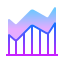 **Gráfico** de la columna tiempo_invertido_dias

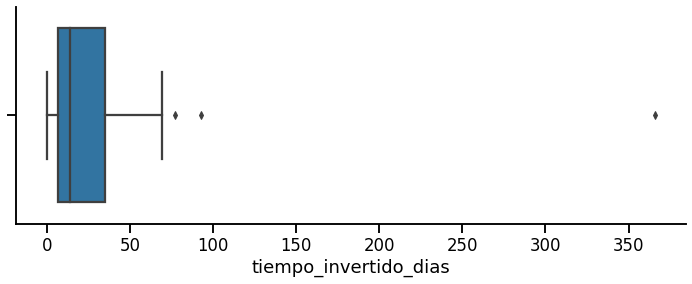

In [ ]:
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_student['tiempo_invertido_dias'])
seaborn.despine()

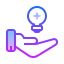 Como podemos ver en el boxplot, existe un user con un valor muy lejano de la mediana y de los intervalos. 

Para poder determinar qué user es, ordenamos los valores de la columna `tiempo_invertido_dias` de mayor a menor y extraemos el primer valor.

In [ ]:
df_student.sort_values(by=['tiempo_invertido_dias'],ascending = False)[:1]

,cant_envios,cant_ejercicios_unicos,f_primer_envio,f_ultimo_envio,tiempo_invertido,tiempo_invertido_horas,tiempo_invertido_dias
student_uid,,,,,,,
97,101,22,2019-09-25 12:16:19.153,2020-09-25 15:44:32.619,366 days 03:28:13.466000,8787.47,366.1446


El valor outlier corresponde al del user con student_uid= 97

In [ ]:
#eliminacion
df_student = df_student[df_student['tiempo_invertido_dias']<=100]

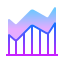 **Gráfico** para checkear la eliminación de outliers de la columna tiempo_invertido_dias

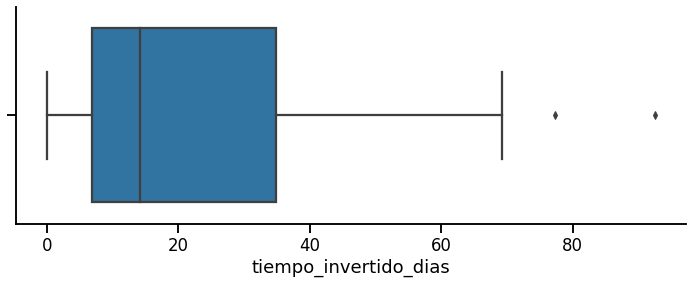

In [ ]:
#checkeo
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_student['tiempo_invertido_dias'])
seaborn.despine()

#Análisis de outliers al analizar la cantidad de envíos por user

Este análisis surgió durante el análisis que puede verse en la otra notebook presentada en este entregable.

Durante el análisis, al explorar los datos se agrupo por estudiante y se calculó la cantidad de envíos por user y a qué cantidad de ejercicios se corresponden estos envíos.

In [ ]:
df_envios=df_mumuki.groupby(['student_uid'], as_index=False).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x))),}).rename(columns={'id_exercise':'Cant_Envios','exercise_name':'Ejercicios_ Resueltos', "student_uid": 'UID del estudiante'})
df_envios

,UID del estudiante,Cant_Envios,Ejercicios_ Resueltos
0,75,1,1
1,76,89,36
2,77,186,40
3,78,84,9
4,79,95,22
...,...,...,...
280,358,6,1
281,359,38,16
282,361,1,1
283,362,3,1


Luego, se procede a analizar estos datos calculados

In [ ]:
df_envios.describe()

,UID del estudiante,Cant_Envios,Ejercicios_ Resueltos
count,285.000000,285.000000,285.000000
mean,217.066667,165.259649,31.161404
std,82.531593,108.395741,13.409133
min,75.000000,1.000000,1.000000
25%,146.000000,86.000000,22.000000
50%,217.000000,149.000000,40.000000
75%,288.000000,223.000000,40.000000
max,363.000000,660.000000,40.000000


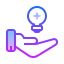 Llamó la atención la columna `Cant_Envios`, ya que es la que tiene los valores mínimos y máximos más alejados entre sí, lo que suele suceder cuando aparecen outliers.

Para verificar esto, graficamos la columna en un boxplot.

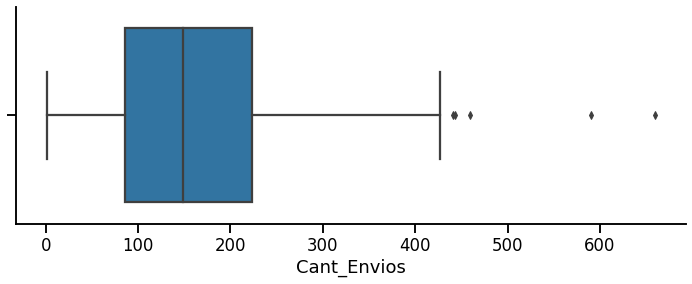

In [ ]:
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_envios['Cant_Envios'])
seaborn.despine()

Definos cómo debemos filtrar estos outliers, que son mucho más grandes que la media de 149 envíos.
Decidimos utilizar los cuartiles como medida de filtro, entre el 2% y el 97% de los datos

In [ ]:
interesting_range_envios = df_envios['Cant_Envios'].quantile([.02, .97])
min = interesting_range_envios.values[0]
max = interesting_range_envios.values[1]
df_envios_2 = df_envios[df_envios['Cant_Envios'].between(min, max)]

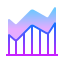 Volvemos a graficar

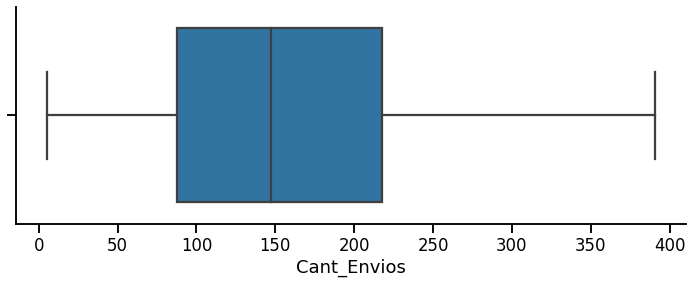

In [ ]:
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_envios_2['Cant_Envios'])
seaborn.despine()

Así, no tendríamos màs outliers.

#Eliminación de valores definidos como outliers

###Eliminacion de outliers relacionados a las fechas

In [ ]:
print(f'Cantidad inicial de users: {len(df_mumuki["student_uid"].value_counts())}')

Cantidad inicial de users: 272


In [ ]:
print(f'Tamaño inicial del dataframe: {len(df_mumuki)}')

Tamaño inicial del dataframe: 42785


Filtramos del dataframe el user identificado como outlier

In [ ]:
df_mumuki=df_mumuki[df_mumuki['student_uid']!=97]

Vemos como queda nuestro dataframe después de eliminarlo

In [ ]:
print(f'Cantidad inicial de users: {len(df_mumuki["student_uid"].value_counts())}')

284

In [ ]:
print(f'Tamaño inicial del dataframe: {len(df_mumuki)}')

46998

<div>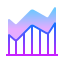 <span>Checkeamos que efectivamente se haya eliminado, utilizando un boxplot</span></div>

In [ ]:
df_student_despues_fechas = df_mumuki.groupby(['student_uid'], as_index=True).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x))),'submission_created_at':'min','created_at':'max'}).rename(columns={'id_exercise':'cant_envios','exercise_name':'cant_ejercicios_unicos','submission_created_at':'f_primer_envio','created_at':'f_ultimo_envio'})
df_student_despues_fechas['tiempo_invertido'] = pd.to_datetime(df_student_despues_fechas['f_ultimo_envio'])-pd.to_datetime(df_student_despues_fechas['f_primer_envio'])
df_student_despues_fechas['tiempo_invertido_horas'] = round((pd.to_datetime(df_student_despues_fechas['f_ultimo_envio'])-pd.to_datetime(df_student_despues_fechas['f_primer_envio'])).dt.total_seconds() / 3600.0,2) 
df_student_despues_fechas['tiempo_invertido_dias'] = round(df_student_despues_fechas['tiempo_invertido_horas']/24,4)

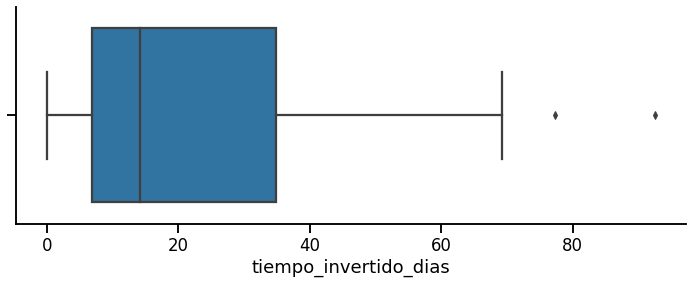

In [ ]:
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_student_despues_fechas['tiempo_invertido_dias'])
seaborn.despine()

Efectivamente, se eliminó el user con una frecuencia de acceso a la pataforma de más de 365 días.

###Eliminacion de outliers relacionados a la cantidad de envíos por user

Vamos a identificar lxs users definidos como outliers relacionados a la cantidad de envíos.

Lxs user con un sólo envío serían:

In [ ]:
# id de students con un solo envío
std_un_solo_envio= df_envios[df_envios['Cant_Envios']==1]['UID del estudiante'].to_list()
std_un_solo_envio

[75, 142, 361]

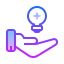 Pasamos a calcular el id de lxs user que superen el percentil de 0.97 definido previamente

In [ ]:
# id de students con cantidad de envios mayor al percentil 0.97
std_envios_97_percentil= df_envios[df_envios['Cant_Envios']>max]['UID del estudiante'].to_list() 
std_envios_97_percentil

[147, 157, 179, 191, 231, 256, 265, 283, 301]

Creamos un array con todos los ids de users a eliminar del dataframe

In [ ]:
filtered_uids_stds=std_un_solo_envio+std_envios_97_percentil

In [ ]:
#eliminacion
df_mumuki=df_mumuki[~df_mumuki['student_uid'].isin(filtered_uids_stds)]

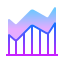 Graficamos nuevamente un boxplot para asegurarnos que se han elimiando los outliers.

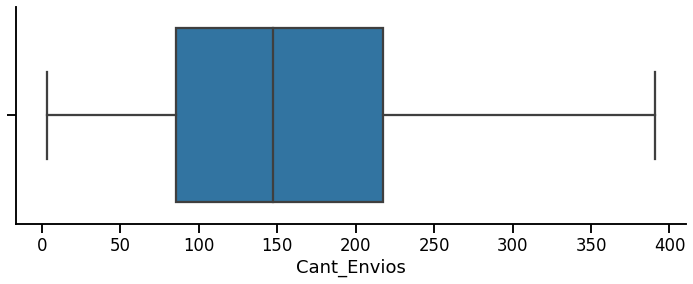

In [ ]:
#validacion
df_envios_sin_otl=df_mumuki.groupby(['student_uid'], as_index=False).agg({'id_exercise':'count','exercise_name': (lambda x: len(set(x))),}).rename(columns={'id_exercise':'Cant_Envios','exercise_name':'Ejercicios_ Resueltos', "student_uid": 'UID del estudiante'})
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_envios_sin_otl['Cant_Envios'])
seaborn.despine()

#### Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas.

In [ ]:
df_mumuki.to_csv('DataSet_Mumuki_Outliers.csv')